In [1]:
# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer)
from sklearn.pipeline import (make_pipeline, make_union)
from sklearn.linear_model import LinearRegression

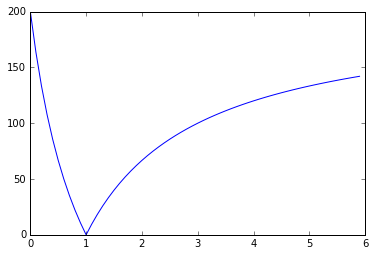

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [30]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)

In [92]:
def windowsAvgs(X, windowT = 100):
    Xheight, Xwidth = X.shape
    windows = np.mean(X[:, -windowT:], axis = 1).reshape(-1,1)
    for start in range(2*windowT, Xwidth, windowT):
        newcol = np.mean(X[:, -start: -start + windowT], axis = 1).reshape(-1,1)
        np.hstack((windows, newcol))
    return windows

def windowsLinear(X, windowT = 100):
    Xheight, Xwidth = X.shape
    linearPart = np.arange(windowT)
    windows = np.dot(X[:,-windowT:], linearPart).reshape(-1,1)
    for start in range(2 * windowT, Xwidth, windowT):
        newcol = np.dot(X[:, -start: -start + windowT], linearPart).reshape(-1,1)
        np.hstack((windows, newcol))
    return windows

def windowsPower(X, power = 2, windowT = 100):
    Xheight, Xwidth = X.shape
    powerVals = np.arange(windowT)**power
    windows = np.dot(X[:,-windowT:], powerVals).reshape(-1,1)
    for start in range(2 * windowT, Xwidth, windowT):
        newcol = np.dot(X[:, -start: -start + windowT], powerVals).reshape(-1,1)
        np.hstack((windows, newcol))
    return windows

def windowsMultiPower(X, power = 2, windowT = 100):
    Xheight, Xwidth = X.shape
    result = np.empty((Xheight, 0))
    for curPower in range(power + 1):
        newArray = windowsPower(X, curPower, windowT)
        result = np.hstack((result, newArray))
    return result

def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

In [9]:
preTransform = make_union( FunctionTransformer(windowsAvgs),
                           FunctionTransformer(windowsLinear),
                           FunctionTransformer(windowsPower, kw_args = {'power':2}) )
                           
model = make_pipeline(preTransform,
                      PolynomialFeatures(2),
                      LinearRegression())
model.fit(X_train, Y_train)
Y_predict = model.predict(X_test)

In [10]:
smape(Y_predict, Y_test)

116.42685184798619

In [11]:
scores = -cross_val_score(model, X_all, Y_all, scoring = smape_scorer)
np.mean(scores)

118.04818082187064

In [46]:
# Let's try linear features after the preTransform

preTransformers = []
scores = []

for power in range(5):
    newtransform = FunctionTransformer(windowsPower, kw_args = {'power' : power, 'windowT' : 64})
    preTransformers.append(newtransform)
    preTransform = make_union(*preTransformers)
    model = make_pipeline(preTransform,
                         PolynomialFeatures(1),
                         LinearRegression())
    score = -cross_val_score(model, X_all, Y_all, scoring = smape_scorer)
    score = np.mean(score)
    scores.append(score)
    print('Power ', power, ' has score = ', score)

Power  0  has score =  114.169344403
Power  1  has score =  112.255266653
Power  2  has score =  112.733945394
Power  3  has score =  112.698832722
Power  4  has score =  112.559663202


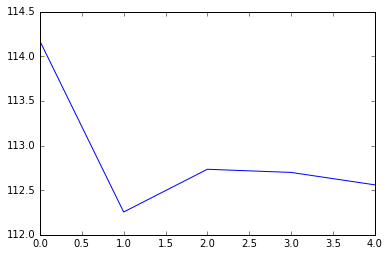

In [47]:
plt.plot(scores)
plt.show()

In [48]:
# Now, let's try quadratic features after the preTransform

preTransformers = []
scores = []

for power in range(5):
    newtransform = FunctionTransformer(windowsPower, kw_args = {'power' : power, 'windowT' : 64})
    preTransformers.append(newtransform)
    preTransform = make_union(*preTransformers)
    model = make_pipeline(preTransform,
                         PolynomialFeatures(2),
                         LinearRegression())
    score = -cross_val_score(model, X_all, Y_all, scoring = smape_scorer)
    score = np.mean(score)
    scores.append(score)
    print('Power ', power, ' has score = ', score)

Power  0  has score =  117.063629044
Power  1  has score =  115.387604568
Power  2  has score =  115.055048775
Power  3  has score =  112.814602291
Power  4  has score =  129.273170834


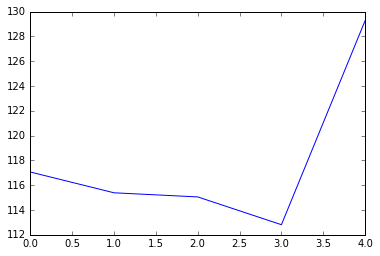

In [49]:
plt.plot(scores)
plt.show()

In [42]:
# Let's try adding in whether Page contains a four digit number (most likely a year date)

hasFourDigit = []
for pageStr in all_df['Page']:
    thisHave = re.match(r'(\b|\D)\d\d\d\d(\b|\D)', pageStr)
    if thisHave == None:
        hasFourDigit.append(0.0)
    else:
        hasFourDigit.append(1.0)
        
all_df['nameHasYear'] = hasFourDigit
hasFourDigit = np.array(hasFourDigit).reshape(-1,1)
print('Number of Pages containing four digit numbers = ', np.sum(hasFourDigit))

[ [x, y] for (x,y) in zip(all_df['Page'].values, hasFourDigit)][:20]

Number of Pages containing four digit numbers =  1154.0


[['2NE1_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['2PM_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['3C_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['4minute_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['5566_zh.wikipedia.org_all-access_spider', array([ 1.])],
 ['91Days_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ["A'N'D_zh.wikipedia.org_all-access_spider", array([ 0.])],
 ['AKB48_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['ASCII_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['ASTRO_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['Ahq_e-Sports_Club_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['All_your_base_are_belong_to_us_zh.wikipedia.org_all-access_spider',
  array([ 0.])],
 ['AlphaGo_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['Android_zh.wikipedia.org_all-access_spider', array([ 0.])],
 ['Angelababy_zh.wikipedia.org_all-

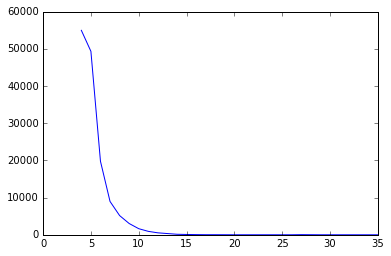

In [66]:
# Let's count the number of occurrences of '_'.

numWords = []
for pageStr in all_df['Page']:
    words = re.split(r'_', pageStr)
    numWords.append(len(words))
    
numWords = np.array(numWords).reshape(-1,1)

vals, counts = np.unique(numWords, return_counts = True)
plt.plot(vals, counts)
plt.show()

all_df['numWords'] = numWords

In [103]:
# Let's put the number of occurrences of '_' in Page into linear regression

X_all2 = np.hstack((X_all, numWords))
all_scores = []

for tPower in range(6):
    preTransformer = FunctionTransformer(windowsMultiPower, kw_args = {'power' : tPower, 'windowT' : 64})
    preTransformer = make_pipeline(FunctionTransformer(lambda X : X[:,:-1]),
                                   preTransformer)

    preTransformer = make_union(FunctionTransformer(lambda X : X[:, -1:].reshape(-1,1)),
                                preTransformer)

    model = make_pipeline(preTransformer,
                          PolynomialFeatures(1),
                          LinearRegression())
    scores = -cross_val_score(model, X_all2, Y_all, scoring = smape_scorer)
    scores = np.mean(scores)
    print('For tPower of ', tPower, ' score = ', scores)
    all_scores.append(scores)

scores

For tPower of  0  score =  113.884718361
For tPower of  1  score =  112.038312406
For tPower of  2  score =  112.576491376
For tPower of  3  score =  112.484267314
For tPower of  4  score =  112.460867832
For tPower of  5  score =  112.957995356


112.95799535615713

In [107]:
# Now try making sure predictions are non-negative

X_all2 = np.hstack((X_all, numWords))
all_scores = []

def smape_scorer2(estimator, X, Y):
    Ypredict = estimator.predict(X)
    Ypredict = np.abs(Ypredict)
    result = smape(Y, Ypredict)
    return -result

for tPower in range(4):
    preTransformer = FunctionTransformer(windowsMultiPower, kw_args = {'power' : tPower, 'windowT' : 64})
    preTransformer = make_pipeline(FunctionTransformer(lambda X : X[:,:-1]),
                                   preTransformer)

    preTransformer = make_union(FunctionTransformer(lambda X : X[:, -1:].reshape(-1,1)),
                                preTransformer)

    model = make_pipeline(preTransformer,
                          PolynomialFeatures(1),
                          LinearRegression())
    scores = -cross_val_score(model, X_all2, Y_all, scoring = smape_scorer2)
    scores = np.mean(scores)
    print('For tPower of ', tPower, ' score = ', scores)
    all_scores.append(scores)

scores

For tPower of  0  score =  113.77533185
For tPower of  1  score =  111.536882747
For tPower of  2  score =  111.789980367
For tPower of  3  score =  111.710147404


111.71014740431609